<a href="https://colab.research.google.com/github/ziyanl/FairnessPrivacyFL/blob/main/Fairness_Federated_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import torch
import torch.utils.data as data
import pandas as pd
import joblib
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from torch.utils.data import DataLoader, Subset, Dataset, random_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from torchvision import datasets
from torchvision.transforms import ToTensor

class AdultDataset(data.Dataset):
    def __init__(self, root, data_filename, test_filename=None, dataidxs=None, train=True, transform=None, target_transform=None, download=False):
        self.root = root
        self.data_filename = data_filename
        self.test_filename = test_filename
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        # Columns names
        columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                  'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                  'hours-per-week', 'native-country', 'income']

        # Load data
        if train:
            self.data = pd.read_csv(os.path.join(root, data_filename), header=None, names=columns, sep=',\s*\.?\s*', engine='python')

            # Handle missing data - omit entries with missing data
            self.data.replace("?", np.nan, inplace=True)
            self.data.dropna(inplace=True)

            self.target = self.data['income']
            self.data = self.data.drop(columns=['income'])

            # Convert target to binary labels: '>50K' becomes 1, '<=50K' becomes 0
            self.target = (self.target == '>50K').astype(int)

            self._fit_preprocess_data()
        else:
            self.data, self.target = self.load_test_data(test_filename)

        # Truncate data if indices are provided
        if self.dataidxs is not None:
            self.data = self.data.iloc[self.dataidxs, :]
            self.target = self.target.iloc[self.dataidxs]

        # Convert data and target to numpy arrays
        self.data = self.data.to_numpy()
        self.target = self.target.to_numpy()

    def _fit_preprocess_data(self):
        # List columns that are categorical and need encoding
        categorical_features = ['workclass', 'education', 'marital-status',
                                'occupation', 'relationship', 'race', 'sex', 'native-country']

        # Create the preprocessing pipelines for both numeric and categorical data
        numeric_features = self.data.select_dtypes(include=['int64', 'float64']).columns.tolist()

        # Define transformers
        numeric_transformer = StandardScaler()
        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'))])

        # Use column transformer to apply transformations to the respective columns
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)])

        # Fit and transform the data and replace the original data
        self.data = pd.DataFrame(preprocessor.fit_transform(self.data).toarray(),
                                 columns=(numeric_features +
                                          list(preprocessor.named_transformers_['cat']['onehot']
                                               .get_feature_names_out(categorical_features))))

        # Store numeric and transformed categorical feature names for later use
        self.numeric_features = numeric_features
        self.categorical_feature_names = list(preprocessor.named_transformers_['cat']['onehot']
                                              .get_feature_names_out(categorical_features))

        joblib.dump(preprocessor, os.path.join(self.root, 'preprocessor.pkl'))
        joblib.dump((numeric_features, self.categorical_feature_names), os.path.join(self.root, 'feature_names.pkl'))

    def load_test_data(self, test_filename):
        # Columns names
        columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                   'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                   'hours-per-week', 'native-country', 'income']

        # Load test data
        test_data = pd.read_csv(os.path.join(self.root, test_filename), header=None, names=columns, sep=',\s*\.?\s*', engine='python')

        # Handle missing data - omit entries with missing data
        test_data.replace("?", np.nan, inplace=True)
        test_data.dropna(inplace=True)

        # Separate target and features
        target = test_data['income']
        test_data = test_data.drop(columns=['income'])

        # Convert target to binary labels: '>50K' becomes 1, '<=50K' becomes 0
        target = (target == '>50K').astype(int)

        # Transform data
        self._transform_data(test_data, target)

        test_data, target = self._transform_data(test_data, target)
        return test_data, target

    def _transform_data(self, data, target):
        # Load the preprocessor and transform the data without refitting:
        loaded_preprocessor = joblib.load(os.path.join(self.root, 'preprocessor.pkl'))

        # Load the feature names
        self.numeric_features, self.categorical_feature_names = joblib.load(os.path.join(self.root, 'feature_names.pkl'))

        data = pd.DataFrame(loaded_preprocessor.transform(data).toarray(),
                            columns=(self.numeric_features +
                                     self.categorical_feature_names))
        # Handle possible periods in the test file labels
        target = target.replace({'>50K.': '>50K', '<=50K.': '<=50K'})

        return data, target

    def find_protected_attribute_index(self, attribute_name):
        # Find post-transformation indices of columns related to a specified attribute
        post_transform_columns = self.numeric_features + self.categorical_feature_names

        # Find columns related to the specified attribute and their indices
        attribute_related_columns = [col for col in post_transform_columns if attribute_name in col]
        indexes_of_attribute_columns = [post_transform_columns.index(col) for col in attribute_related_columns]

        return attribute_related_columns, indexes_of_attribute_columns

    def get_protected_attributes(self, attribute_name):
        if attribute_name in self.columns:  # Assuming 'columns' has the original column names
            # Load the original dataset to access the untransformed attributes
            full_data = pd.read_csv(os.path.join(self.root, self.data_filename), header=None, names=self.columns, sep=',\s*\.?\s*', engine='python')
            # Return the specified attribute
            return full_data[attribute_name].to_numpy()
        else:
            raise ValueError(f"Attribute {attribute_name} not found in dataset.")

    def get_test_data(self):
        return self.test_data, self.target[self.data.shape[0]:]

    @property
    def input_dim(self):
        return self.data.shape[1]

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (data, target) where target is index of the target class.
        """
        sample, target = self.data[index], self.target[index]

        if self.transform is not None:
            sample = self.transform(sample)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return torch.Tensor(sample.astype(np.float32)), torch.Tensor([target]).long()

    def __len__(self):
        return len(self.data)

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim=1):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_federated_data(dataset, num_clients):
    data_size = len(dataset)
    indices = list(range(data_size))
    client_indices = np.array_split(indices, num_clients)
    federated_data = []
    for client_idx in client_indices:
        subset = Subset(dataset, client_idx)
        federated_data.append(DataLoader(subset, batch_size=32, shuffle=True))
    return federated_data

class FederatedLearningClient:
    def __init__(self, model, train_loader, test_loader, criterion, optimizer):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion = criterion
        self.optimizer = optimizer

    def local_train(self):
        self.model.train()
        total_loss = 0.0
        for data, target in self.train_loader:
            data, target = data.to(device), target.to(device)
            target = target.view(-1)  # Convert target to 1-dimensional tensor
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.criterion(output.view(-1), target.float())
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(self.train_loader)

    def local_evaluate(self):
        # Put the model in evaluation mode
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0
        # Initialize metrics for precision, recall, and F1-score
        TP = 0  # True Positives
        TN = 0  # True Negatives
        FP = 0  # False Positives
        FN = 0  # False Negatives

        # Disable gradient computation since it's not needed during evaluation
        with torch.no_grad():
            for data, target in self.test_loader:
                # Move the data and target to the device (CPU/GPU)
                data, target = data.to(device), target.to(device)
                # Flatten the target tensor to match output dimensions
                target = target.view(-1)
                # Compute the model output
                output = self.model(data)

                # Calculate loss between output and target
                loss = self.criterion(output.view(-1), target.float())
                total_loss += loss.item()
                # Determine predicted classes (above 0.5 becomes class 1, below becomes class 0)
                predicted = (output > 0.5).float().view(-1)

                # Count the number of correct predictions
                correct += (predicted == target.float()).sum().item()
                # Update the metrics for precision, recall, and F1-score
                TP += ((predicted == 1) & (target == 1)).sum().item()
                TN += ((predicted == 0) & (target == 0)).sum().item()
                FP += ((predicted == 1) & (target == 0)).sum().item()
                FN += ((predicted == 0) & (target == 1)).sum().item()
                total += target.size(0)

        # Compute overall accuracy
        accuracy = 100 * correct / total
        # Compute precision, recall, and F1-score
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        # Return a dictionary of metrics
        return {
            'loss': total_loss / len(self.test_loader),
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score
        }

    def get_local_predictions_and_labels(self):
        self.model.eval()
        predictions, labels = [], []
        with torch.no_grad():
            for data, target in self.test_loader:
                data = data.to(device)
                output = self.model(data)
                predicted = (output > 0.5).float().view(-1)  # Assuming binary classification
                predictions.extend(predicted.cpu().numpy())
                labels.extend(target.cpu().numpy())
        return np.array(predictions), np.array(labels)

    def get_local_protected_attributes(self, attribute_name):
        # Assuming that the dataset class has a method 'get_protected_attributes'
        return self.test_loader.dataset.get_protected_attributes(attribute_name)

# Define the function for averaging weights
def average_weights(local_weights):
    """Calculate the average of the weights."""
    average_weights = {}
    for key in local_weights[0].keys():
        average_weights[key] = torch.sum(torch.stack([weights[key] for weights in local_weights]), dim=0) / len(local_weights)
    return average_weights

class FederatedLearningServer:
    def __init__(self, global_model, clients):
        self.global_model = global_model
        self.clients = clients

    def federated_train(self, num_rounds):
        global_metrics = {
            'losses': [],
            'accuracies': [],
            'precisions': [],
            'recalls': [],
            'f1_scores': []
        }
        for round in range(num_rounds):
            local_weights = []
            for client in self.clients:
                local_loss = client.local_train()
                local_weights.append(client.model.state_dict())
                print(f"Local training loss: {local_loss}")

                # Here we access the metrics directly by keys instead of by indices
                metrics = client.local_evaluate()
                global_metrics['losses'].append(metrics['loss'])
                global_metrics['accuracies'].append(metrics['accuracy'])
                global_metrics['precisions'].append(metrics['precision'])
                global_metrics['recalls'].append(metrics['recall'])
                global_metrics['f1_scores'].append(metrics['f1_score'])

            # Aggregate local weights to update global model
            global_weights = average_weights(local_weights)
            self.global_model.load_state_dict(global_weights)

            # Update local models
            for client in self.clients:
                client.model.load_state_dict(global_weights)

            # Here we print out the average of the metrics for each round
            print(f"Global training loss: {np.mean(global_metrics['losses'])}, "
                  f"accuracy: {np.mean(global_metrics['accuracies'])}, "
                  f"precision: {np.mean(global_metrics['precisions'])}, "
                  f"recall: {np.mean(global_metrics['recalls'])}, "
                  f"F1 Score: {np.mean(global_metrics['f1_scores'])}")

        return global_metrics

    def federated_evaluate(self):
        # Initialize total metrics for aggregation
        total_loss = 0.0
        total_accuracy = 0.0
        total_precision = 0.0
        total_recall = 0.0
        total_f1_score = 0.0
        total_clients = len(self.clients)

        # Evaluate each client's model
        for client in self.clients:
            # Obtain evaluation metrics from the client
            metrics = client.local_evaluate()
            total_loss += metrics['loss']
            total_accuracy += metrics['accuracy']
            total_precision += metrics['precision']
            total_recall += metrics['recall']
            total_f1_score += metrics['f1_score']
            print(f"Client evaluation - Loss: {metrics['loss']}, Accuracy: {metrics['accuracy']}, Precision: {metrics['precision']}, Recall: {metrics['recall']}, F1 Score: {metrics['f1_score']}")

        # Calculate the average metrics across all clients
        avg_loss = total_loss / total_clients
        avg_accuracy = total_accuracy / total_clients
        avg_precision = total_precision / total_clients
        avg_recall = total_recall / total_clients
        avg_f1_score = total_f1_score / total_clients

        # Print the global evaluation metrics
        print(f"Global evaluation - Loss: {avg_loss}, Accuracy: {avg_accuracy}, Precision: {avg_precision}, Recall: {avg_recall}, F1 Score: {avg_f1_score}")

        # Return the aggregated metrics
        return {
            'loss': avg_loss,
            'accuracy': avg_accuracy,
            'precision': avg_precision,
            'recall': avg_recall,
            'f1_score': avg_f1_score
        }

Input dimension: 104
Hidden dimensions: [128, 64]
Output dimension: 1
Local training loss: 0.4526891368000131
Local training loss: 0.45802569122690906
Local training loss: 0.45492830370601856
Local training loss: 0.4628952133028131
Local training loss: 0.46489990322213426
Local training loss: 0.4402220622489327
Local training loss: 0.4396596932097485
Local training loss: 0.4552226479116239
Local training loss: 0.4487510274899633
Local training loss: 0.45397213760175203
Global training loss: 0.4043536500819423, accuracy: 76.8957503320053, precision: 0.0, recall: 0.0, F1 Score: 0.0
Local training loss: 0.33905760002763646
Local training loss: 0.33761731229330366
Local training loss: 0.3289949462602013
Local training loss: 0.3503230207844784
Local training loss: 0.3377588261114924
Local training loss: 0.3283848684085043
Local training loss: 0.329270963841363
Local training loss: 0.3332554119197946
Local training loss: 0.32094862398348356
Local training loss: 0.34109204584046415
Global tra

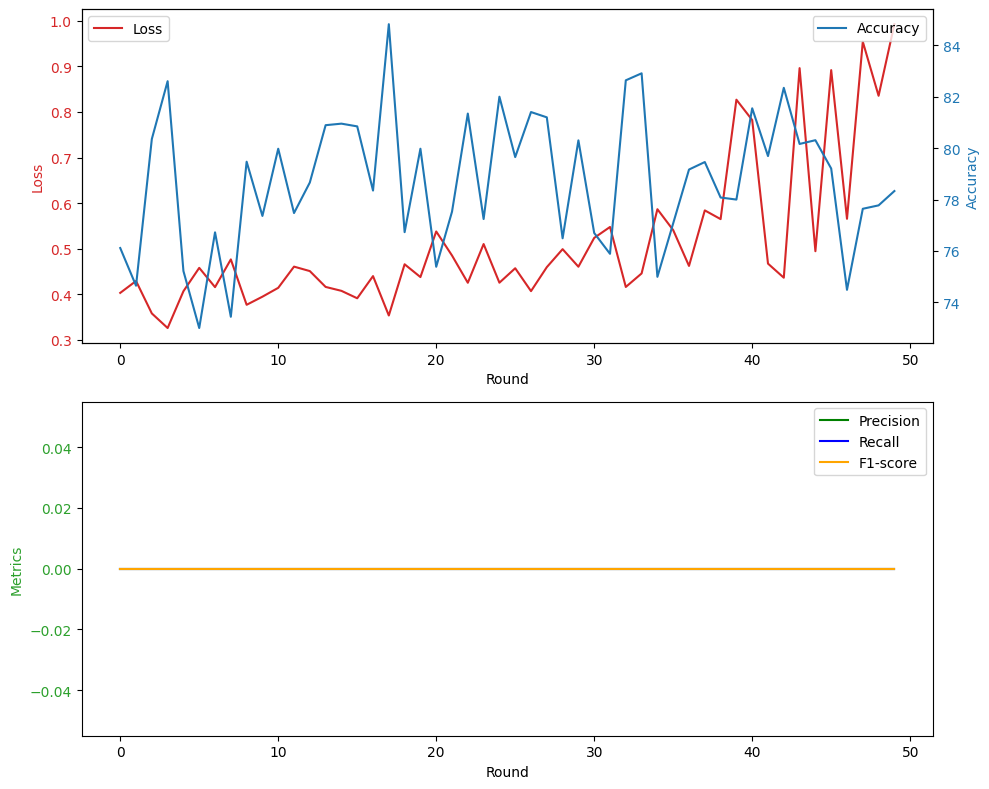

In [ ]:
# Load data
train_data = AdultDataset(root='./sample_data', data_filename="adult.data", train=True)
test_data = AdultDataset(root='./sample_data', data_filename="adult.data", test_filename="adult.test", train=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Get input dimension from the dataset
input_dim = train_data.input_dim
hidden_dims = [128, 64]
output_dim = 1


print(f"Input dimension: {input_dim}")
print(f"Hidden dimensions: {hidden_dims}")
print(f"Output dimension: {output_dim}")


# Create federated data splits
num_clients = 10
federated_train_data = create_federated_data(train_data, num_clients)

# Instantiate global model
global_model = SimpleNN(input_dim, hidden_dims, output_dim).to(device)

# Instantiate clients
clients = []
for train_loader in federated_train_data:
    client_model = copy.deepcopy(global_model)
    client_optimizer = torch.optim.Adam(client_model.parameters(), lr=0.001)
    criterion = torch.nn.BCELoss()
    client = FederatedLearningClient(client_model, train_loader, test_loader, criterion, client_optimizer)
    clients.append(client)

# Instantiate server
server = FederatedLearningServer(global_model, clients)

# Train the global model using federated learning
metrics = server.federated_train(num_rounds=5)
losses = metrics['losses']
accuracies = metrics['accuracies']
precisions = metrics['precisions']
recalls = metrics['recalls']
f1_scores = metrics['f1_scores']

# Evaluate the global model's performance
server.federated_evaluate()

# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot for loss and accuracy
color = 'tab:red'
ax1.set_xlabel('Round')
ax1.set_ylabel('Loss', color=color)
ax1.plot(losses, color=color, label='Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax3 = ax1.twinx()
color = 'tab:blue'
ax3.set_ylabel('Accuracy', color=color)
ax3.plot(accuracies, color=color, label='Accuracy')
ax3.tick_params(axis='y', labelcolor=color)
ax3.legend(loc='upper right')

# Plot for precision, recall, and F1-score
color = 'tab:green'
ax2.set_xlabel('Round')
ax2.set_ylabel('Metrics', color=color)
ax2.plot(precisions, color='green', label='Precision')
ax2.plot(recalls, color='blue', label='Recall')
ax2.plot(f1_scores, color='orange', label='F1-score')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend()

fig.tight_layout()
plt.show()

In [ ]:
def calculate_eop(true_labels, predicted_labels, protected_attributes):
    eop_metrics = {}
    for group in np.unique(protected_attributes):
        group_mask = (protected_attributes == group)
        true_positive = np.logical_and(predicted_labels[group_mask] == 1, true_labels[group_mask] == 1).sum()
        actual_positive = (true_labels[group_mask] == 1).sum()
        eop_metrics[group] = {'tpr': true_positive / actual_positive if actual_positive != 0 else 0}
    return eop_metrics

def calculate_eod(true_labels, predicted_labels, protected_attributes):
    eod_metrics = {}
    for group in np.unique(protected_attributes):
        group_mask = (protected_attributes == group)
        true_positive = np.logical_and(predicted_labels[group_mask] == 1, true_labels[group_mask] == 1).sum()
        false_positive = np.logical_and(predicted_labels[group_mask] == 1, true_labels[group_mask] == 0).sum()
        actual_positive = (true_labels[group_mask] == 1).sum()
        actual_negative = (true_labels[group_mask] == 0).sum()
        tpr = true_positive / actual_positive if actual_positive != 0 else 0
        fpr = false_positive / actual_negative if actual_negative != 0 else 0
        eod_metrics[group] = {'tpr': tpr, 'fpr': fpr}
    return eod_metrics

def calculate_dip(predicted_labels, protected_attributes):
    dip_metrics = {}
    for group in np.unique(protected_attributes):
        group_mask = (protected_attributes == group)
        positive_rate_group = (predicted_labels[group_mask] == 1).mean()
        dip_metrics[group] = positive_rate_group
    overall_positive_rate = (predicted_labels == 1).mean()
    for group in dip_metrics:
        dip_metrics[group] /= overall_positive_rate
    return dip_metrics

def calculate_dop(predicted_labels, protected_attributes):
    dop_metrics = {}
    for group in np.unique(protected_attributes):
        group_mask = (protected_attributes == group)
        positive_rate_group = (predicted_labels[group_mask] == 1).mean()
        dop_metrics[group] = {'positive_rate': positive_rate_group}
    return dop_metrics

In [ ]:
def client_fairness_metrics(client, attribute_name):
    true_labels, predicted_labels = client.get_local_predictions_and_labels()
    protected_attributes = client.get_local_protected_attributes(attribute_name)

    eod_metrics = calculate_eod(true_labels, predicted_labels, protected_attributes)
    eop_metrics = calculate_eop(true_labels, predicted_labels, protected_attributes)
    dop_metrics = calculate_dop(predicted_labels, protected_attributes)
    dip_metrics = calculate_dip(predicted_labels, protected_attributes)

    return eod_metrics, eop_metrics, dop_metrics, dip_metrics

def aggregate_fairness_metrics(clients, attribute_name):
    aggregated_eod_metrics = {}
    aggregated_eop_metrics = {}
    aggregated_dop_metrics = {}
    aggregated_dip_metrics = {}

    for client in clients:
        predicted_labels, true_labels = client.get_local_predictions_and_labels()
        protected_attributes = client.get_local_protected_attributes('race')

        eod_metrics, eop_metrics, dop_metrics, dip_metrics = client_fairness_metrics(client, attribute_name)

        for group in eod_metrics:
            if group not in aggregated_eod_metrics:
                aggregated_eod_metrics[group] = {'tpr': 0, 'fpr': 0}
            aggregated_eod_metrics[group]['tpr'] += eod_metrics[group]['tpr']
            aggregated_eod_metrics[group]['fpr'] += eod_metrics[group]['fpr']

        for group in eop_metrics:
            if group not in aggregated_eop_metrics:
                aggregated_eop_metrics[group] = {'tpr': 0}
            aggregated_eop_metrics[group]['tpr'] += eop_metrics[group]['tpr']

        for group in dop_metrics:
            if group not in aggregated_dop_metrics:
                aggregated_dop_metrics[group] = {'positive_rate': 0}
            aggregated_dop_metrics[group]['positive_rate'] += dop_metrics[group]['positive_rate']

        for group in dip_metrics:
            if group not in aggregated_dip_metrics:
                aggregated_dip_metrics[group] = 0
            aggregated_dip_metrics[group] += dip_metrics[group]

    num_clients = len(clients)
    for group in aggregated_eod_metrics:
        aggregated_eod_metrics[group]['tpr'] /= num_clients
        aggregated_eod_metrics[group]['fpr'] /= num_clients

    for group in aggregated_eop_metrics:
        aggregated_eop_metrics[group]['tpr'] /= num_clients

    for group in aggregated_dop_metrics:
        aggregated_dop_metrics[group]['positive_rate'] /= num_clients

    for group in aggregated_dip_metrics:
        aggregated_dip_metrics[group] /= num_clients

    return aggregated_eod_metrics, aggregated_eop_metrics, aggregated_dop_metrics, aggregated_dip_metrics

def print_fairness_metrics(aggregated_metrics):
    for metric_name, metrics in aggregated_metrics.items():
        print(f"--- {metric_name.upper()} ---")
        for group, values in metrics.items():
            print(f"Group {group}:")
            for key, value in values.items():
                print(f"  {key}: {value:.4f}")
        print("\n")

def plot_fairness_metrics(aggregated_metrics):
    groups = list(aggregated_metrics['EOD'].keys())
    metrics = list(aggregated_metrics.keys())

    n_groups = len(groups)
    n_metrics = len(metrics)

    fig, axs = plt.subplots(n_metrics, 1, figsize=(12, 4 * n_metrics))

    for i, metric in enumerate(metrics):
        values = [aggregated_metrics[metric][group] for group in groups]
        # Assuming each metric has the same set of sub-metrics (like 'tpr', 'fpr')
        sub_metrics = list(values[0].keys())

        for sub_metric in sub_metrics:
            sub_metric_values = [value[sub_metric] for value in values]
            axs[i].bar(groups, sub_metric_values, label=sub_metric)

        axs[i].set_title(metric)
        axs[i].set_ylabel('Value')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

# Then, when calling these functions:
attribute_name = 'race'  # or any other attribute you are analyzing
aggregated_metrics = aggregate_fairness_metrics(clients, attribute_name)

# Printing and plotting
print_fairness_metrics(aggregated_metrics)
plot_fairness_metrics(aggregated_metrics)

AttributeError: ignored